In [5]:
from skimage import io as skio

import scipy.io
import h5py

from glob import glob

from scipy import interpolate

from scipy.interpolate import interp2d

from scipy.spatial import Delaunay

from skimage.draw import polygon


import numpy as np

import skimage as sk
import skimage.io as skio



from PIL import Image as im



import math

import cv2

from tqdm import tqdm

import pickle



import matplotlib.pyplot as plt


In [78]:
from skimage.transform import resize


In [151]:
def display_dictionary_of_images(dic, prefix = '', horiz = False, w = 6, h = 5, normalize_rgb = False):
    %matplotlib inline
    
    if horiz:
    
        fig = plt.figure(figsize=(w * len(dic), h))
        try:
            subplots = list(fig.subplots(1, len(dic)))
        except:
            subplots = [fig.subplots(1, len(dic))]
    else:
        fig = plt.figure(figsize=(w, h * len(dic)))
        try:
            subplots = list(fig.subplots(len(dic), 1))
        except:
            subplots = [fig.subplots(len(dic), 1)]
    
    keylist = list(dic.keys())
    
    for i in range(len(dic)):
        key = keylist[i]      
        pixels = dic[key]

        #Display the image
        ax = subplots[i]
        ax.set_title(prefix + ' ' + key)
        if len(pixels.shape) == 2:
            # grayscale (scalars)
            ax.imshow(pixels,cmap='Greys_r')
        if len(pixels.shape) == 3:
            # rgb
            # gotta normalize the rgb ones too!
            if normalize_rgb:
                pixels = pixels - np.min(pixels)
                pixels = pixels / np.max(pixels)
            ax.imshow(pixels)
def display_grid_of_images(array_of_images, array_of_names, w = 6, h = 5, normalize_rgb = False):
    num_rows = len(array_of_images)
    num_cols = len(array_of_images[0])
    
    assert len(array_of_names) == num_rows, "same num of rows for names and images"
    
    assert all([len(row) == num_cols for row in array_of_images]), "all rows need to be same length"
    assert all([len(row) == num_cols for row in array_of_names]), "all rows need to be same length for strings too"
    
    fig = plt.figure(figsize=(w * num_cols, h * num_rows))
    subplots = fig.subplots(num_rows, num_cols)
    
    for row in range(num_rows):
        for col in range(num_cols):
            
            ax = subplots[row, col]
            ax.set_title(array_of_names[row][col])
            pixels = array_of_images[row][col]
            
            if len(pixels.shape) == 2:
                # grayscale (scalars)
                ax.imshow(pixels,cmap='Greys_r')
            if len(pixels.shape) == 3:
                # rgb
                if normalize_rgb:
                    # gotta normalize the rgb ones too!
                    pixels = pixels - np.min(pixels)
                    pixels = pixels / np.max(pixels)
                ax.imshow(pixels)


In [13]:
top_breeds = ['005.alaskan_malamute','015.basset_hound','029.border_collie','039.bull_terrier','057.dalmatian','041.bullmastiff','087.irish_terrier','056.dachshund','016.beagle','012.australian_shepherd']

with open('sfm_warp_data/mean_points.pickle', 'rb') as handle:
    mean_points_2d = pickle.load(handle)
with open('sfm_warp_data/3d_points.pickle', 'rb') as handle:
    points_meanaligned_3d = pickle.load(handle)

In [14]:
def add_corners_2(ptset):
    corners = np.array([[0, 0, 223, 223], [0, 223, 0, 223]])
    return np.hstack([ptset, corners])

def add_corners_3(ptset):
    corners = np.array([[0, 0, 223, 223], [0, 223, 0, 223], [0, 0, 0, 0]])
    return np.hstack([ptset, corners])   

### Delauney (run only once)

get overall mean points

In [16]:
mean_points_all = np.zeros((2, 13))
for this_mean in mean_points_2d.values():
    mean_points_all += this_mean
mean_points_all /= len(mean_points_2d.values())
mean_points_all = add_corners_2(mean_points_all)

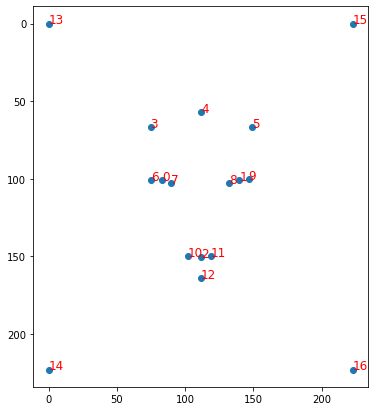

In [17]:
plt.figure(figsize=(6, 7))
plt.gca().invert_yaxis()
plt.scatter(*mean_points_all)
for i in range(17):
    plt.text(mean_points_all[0, i], mean_points_all[1, i], str(i), color="red", fontsize=12)

In [18]:
triangulation = Delaunay(mean_points_all.T)

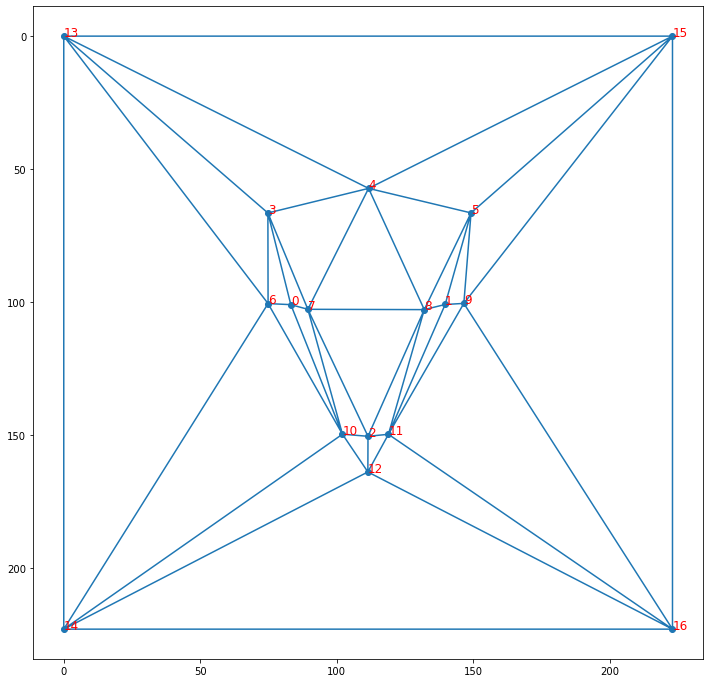

In [20]:
%matplotlib inline
plt.figure(figsize=(12, 12))
plt.gca().invert_yaxis()

plt.scatter(*mean_points_all)
plt.triplot(mean_points_all[0], mean_points_all[1], triangulation.simplices)
for i in range(17):
    plt.text(mean_points_all[0, i], mean_points_all[1, i], str(i), color="red", fontsize=12)

In [162]:
simplices=[
        [12, 16, 14],
    [12, 11, 16],
    [11,  9, 16],
    [16,  9, 15],
    [11,  1,  9],
    [ 1,  5,  9],
    [ 9,  5, 15],
    [ 1, 11,  8],
    [ 5,  1,  8],
   
        [ 4,  5,  8],
    [ 5,  4, 15],
    [ 7,  4,  8],
     [11,  2,  8],
    [ 2,  7,  8],
    [ 7,  2, 10],
    [10, 12, 14],


        [ 6, 14, 13],
    [15,  4, 13],
    [ 3,  6, 13],
    [ 4,  3, 13],
    [ 6, 10, 14],
    [ 7,  3,  4],
    [ 0, 10,  6],
    [ 0,  7, 10],
    [ 3,  0,  6],
    [ 7,  0,  3],
    
            [ 2, 11, 12],
    [10,  2, 12],

]

## Face morphing

### methods (from project 3)

In [51]:
"""
use inverse warp to do one triangle, in one direction
params:
1. simplex - the 3 indices connected by the triangle
2. pts_1 - original point coordinates
3. pts_2 - the new points

returns:
a matrix : ) 
"""
def calculate_one_triangle(simplex, pts_1, pts_2, src_img, dest_img):
    
    # get the triangle corners
    orig_points = pts_1[simplex]
    new_points = pts_2[simplex]
    
    # get the polygon index for source and dest
    old_poly = polygon(orig_points[:,1], orig_points[:,0])
    newpoly = polygon(new_points[:,1], new_points[:,0])
    
    
    
    # get the pixel values for the old image
    r_old = src_img[:,:,0][old_poly]
    g_old = src_img[:,:,1][old_poly]
    b_old = src_img[:,:,2][old_poly]
    
    # get the inverse warp matrix
    tmx = computeAffine(simplex, pts_1, pts_2)
    tmx_i = np.linalg.inv(tmx)
    
    # do the inverse warp
    dest_pixels_matrix = np.vstack((newpoly[1], newpoly[0], np.ones(len(newpoly[0]))))
    inverse_warp = (tmx_i @ dest_pixels_matrix)[:2]
    # interpolate
    try:
        r_new = interpolate.griddata((old_poly), r_old, (inverse_warp[1], inverse_warp[0]), method='nearest')
    except:
        r_new = np.zeros(len(newpoly[0]))
    try:
        g_new = interpolate.griddata((old_poly), g_old, (inverse_warp[1], inverse_warp[0]), method='nearest')
    except:
        g_new = np.zeros(len(newpoly[0]))
    try:
        b_new = interpolate.griddata((old_poly), b_old, (inverse_warp[1], inverse_warp[0]), method='nearest')
    except:
        b_new = np.zeros(len(newpoly[0]))
    
    triangle = np.vstack((r_new, g_new,b_new)).T
    triangle = np.clip(triangle, 0, 1)
    
    #apply pixels to dest image
    dest_img[newpoly[0],newpoly[1]] = triangle


def computeAffine(simplex, pts_1, pts_2):
    orig_points = pts_1[simplex]

    new_points = pts_2[simplex]

    b = new_points
    A = np.hstack([orig_points, np.ones(3).reshape((3,1))])

    x = np.linalg.solve(A, b)

    tmx = np.vstack([x.T, [0,0,1]])
    return tmx

"""
this is the same code as the previous section, just with some names changed
"""

def morph(im1, im2, im1_pts, im2_pts, simplices, warp_frac, dissolve_frac):
    
    assert im1.shape == im2.shape
    assert len(im1_pts) == len(im2_pts)

    target_points = (im1_pts * warp_frac) + (im2_pts * (1 - warp_frac))
    
    im1_warped = np.zeros(im1.shape, dtype = float)
    im2_warped = np.zeros(im1.shape, dtype = float)
    
    for idx, simplex in enumerate(simplices):
        calculate_one_triangle(simplex, im1_pts, target_points, im1, im1_warped)
        calculate_one_triangle(simplex, im2_pts, target_points, im2, im2_warped)
        
    combined = im1_warped*dissolve_frac + im2_warped*(1-dissolve_frac)
    return combined

### execution

In [7]:
with open('sfm_warp_data/mean_images.pickle', 'rb') as handle:
    mean_faces_2d = pickle.load(handle)

In [105]:
# mean_faces_2d = {}

# for BREED in tqdm(top_breeds):

#     mats = glob(f'CU_dogs/training_133/{BREED}/*v5.mat')
#     mats.sort()

#     breed_mean = add_corners_2(mean_points_2d[BREED])

#     warped_to_avg = []

#     for idx, name in enumerate(mats):
#         mat = scipy.io.loadmat(name)
#         img = mat['Imask'].astype(float)/255
#         pts = add_corners_2(mat['points'])

#         # warp fraction is 0 because we want to use entirely the second set of poitns
#         # dissolve fraction is 1 because we want to use entirely the original pixels
#         warped = morph(img, img, pts.T, breed_mean.T, simplices, 0, 1)
#         warped_to_avg.append(warped)



#     mean_face = sum(warped_to_avg)/len(warped_to_avg)
    
#     mean_faces_2d[BREED] = mean_face

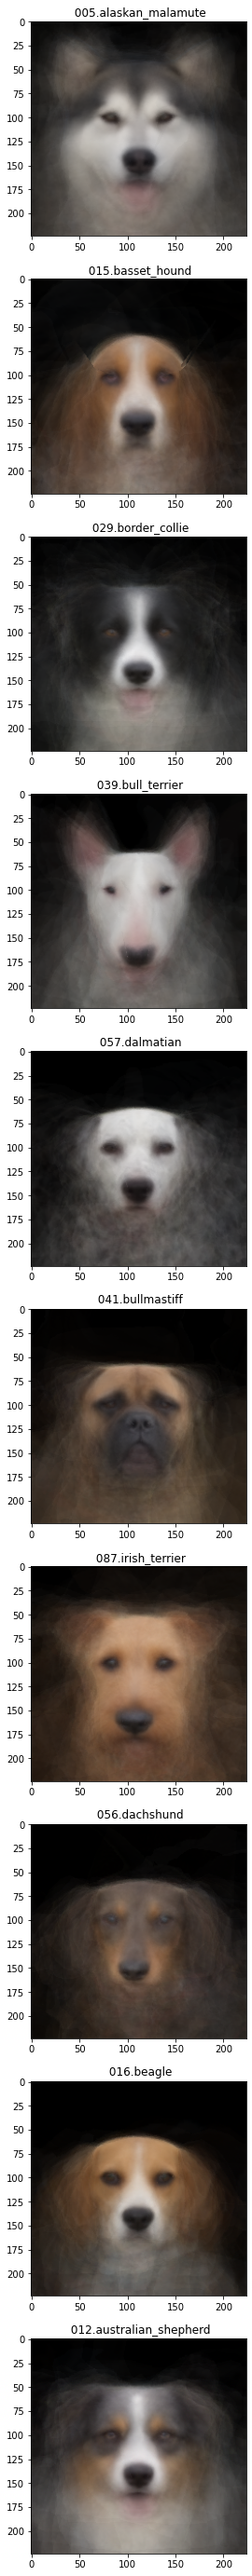

In [8]:
display_dictionary_of_images(mean_faces_2d)

In [9]:
# with open('sfm_warp_data/mean_images.pickle', 'wb') as handle:
#     pickle.dump(mean_faces_2d, handle, protocol=pickle.HIGHEST_PROTOCOL)

### do the 3d

In [137]:
def toIsometric2D(three_d_pts):
    x, y, z = three_d_pts
    u=-(x-z)/math.sqrt(2);
    v=(x+2*y+z)/math.sqrt(6);
    return np.vstack((u, v))


NameError: name 'breeds' is not defined

In [45]:
BREED = '005.alaskan_malamute'

In [10]:
with open('sfm_warp_data/3d_points.pickle', 'rb') as handle:
    points_meanaligned_3d = pickle.load(handle)

In [163]:
kinda_3d = {}
for BREED in top_breeds:

    points_meanaligned_iso = toIsometric2D(add_corners_3(points_meanaligned_3d[BREED]))
    mins = np.min(points_meanaligned_iso, axis=1)
    points_meanaligned_iso -= mins.reshape((2,1))


    img = np.array(mean_faces_2d[BREED])
    img = resize(img, (int(np.max(points_meanaligned_iso)) + 1,int(np.max(points_meanaligned_iso)) + 1))


    mean_2d = add_corners_2(mean_points_2d[BREED])


    rsz_factor = (np.max(points_meanaligned_iso) + 1) / 224


    mean_2d = mean_2d * rsz_factor

    warped = morph(img, img, mean_2d.T, points_meanaligned_iso.T, simplices, 0, 1)

    warp_cropped = warped[50:250, :175]
    kinda_3d[BREED] = warp_cropped


### display

In [164]:
imgs = []
titles = []
for BREED in top_breeds:
    imgs.append( [mean_faces_2d[BREED],kinda_3d[BREED]])
    titles.append([f"{BREED}_flat", f"{BREED}_3dish"])

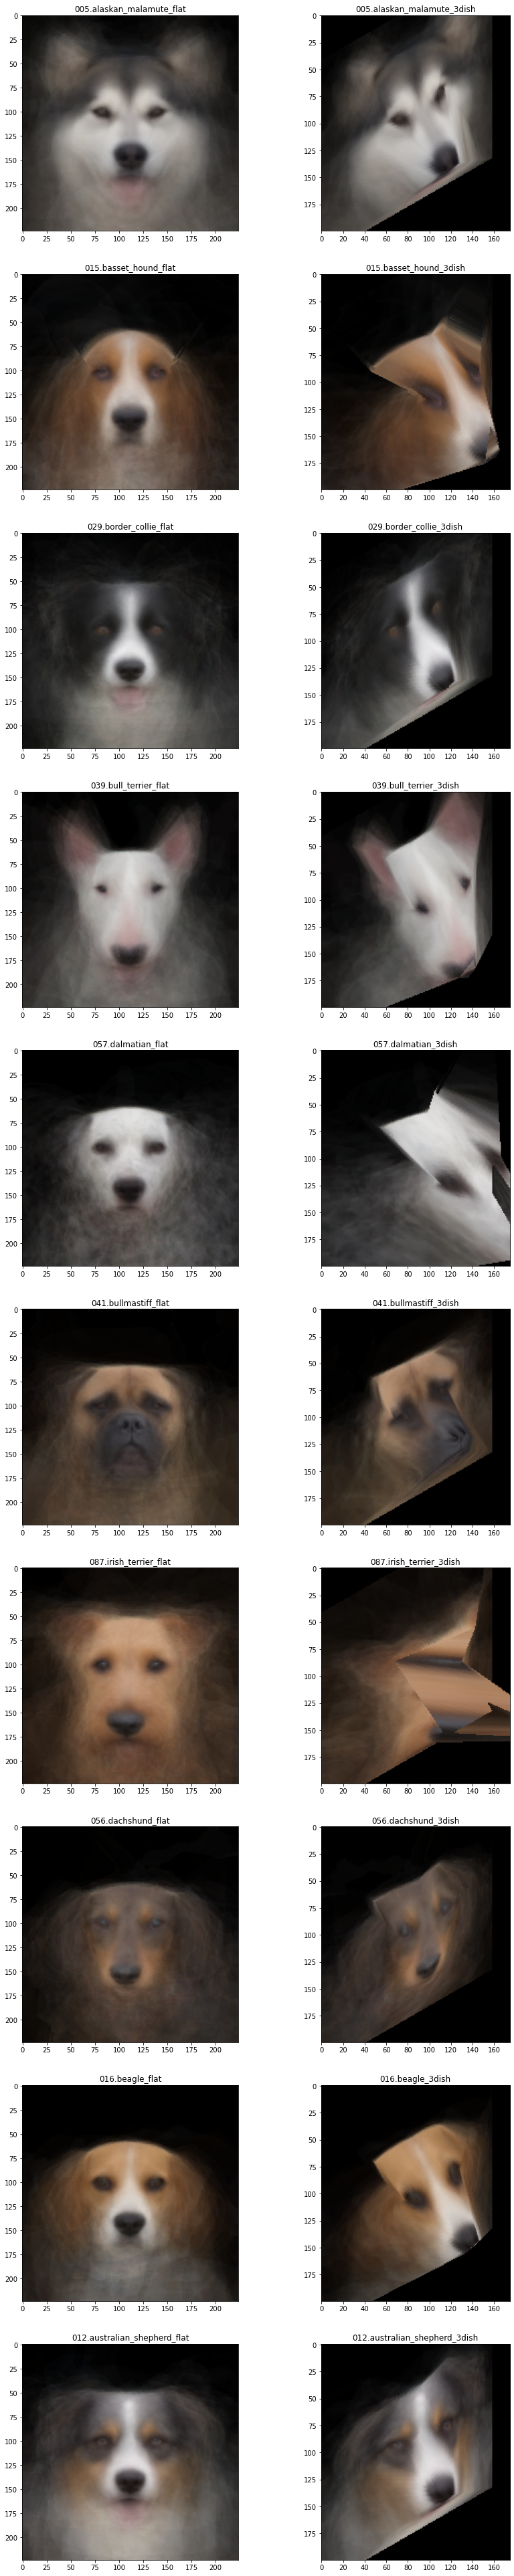

In [166]:
display_grid_of_images(imgs, titles, w = 7, h = 7)